In [9]:
# Встановлюємо OpenCV та інші необхідні бібліотеки
#!pip install opencv-python numpy

# Завантажуємо файли YOLOv3
!wget -q https://pjreddie.com/media/files/yolov3.weights -O yolov3.weights
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -O yolov3.cfg
!wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names -O coco.names


Зображення успішно завантажено!


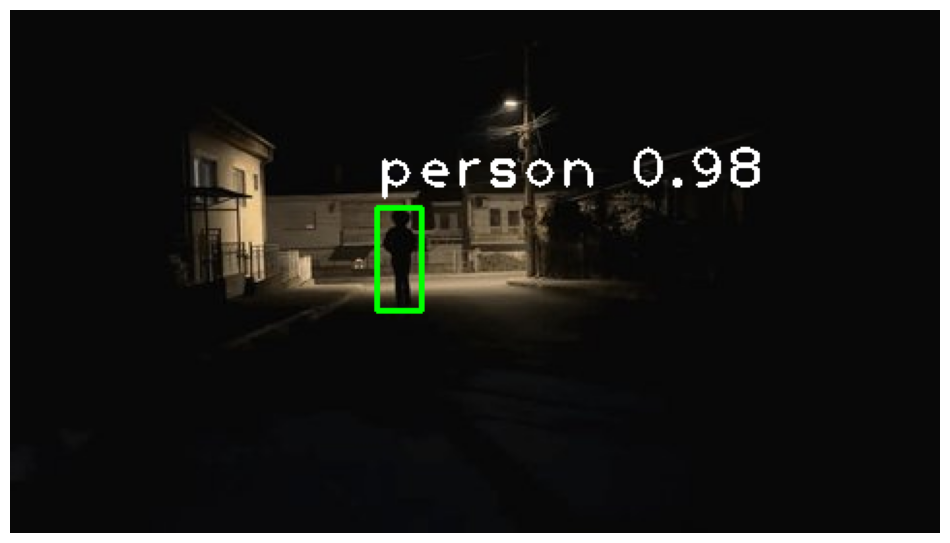

In [14]:
import cv2
import numpy as np
import urllib.request

# URL вашого зображення
image_url = 'https://www.shutterstock.com/shutterstock/videos/3511622129/thumb/1.jpg?ip=x480'

# Завантажуємо зображення за посиланням
resp = urllib.request.urlopen(image_url)
image = np.asarray(bytearray(resp.read()), dtype="uint8")
image = cv2.imdecode(image, cv2.IMREAD_COLOR)

if image is None:
    print('Не вдалося завантажити зображення. Перевірте URL та його доступність.')
else:
    print('Зображення успішно завантажено!')

    # Отримуємо розміри зображення
height, width = image.shape[:2]

# Завантажуємо нейронну мережу YOLOv3
net = cv2.dnn.readNet('yolov3.weights', 'yolov3.cfg')

# Завантажуємо назви класів
classes = []
with open('coco.names', 'r') as f:
    classes = f.read().splitlines()

# Підготовка зображення для нейронної мережі
blob = cv2.dnn.blobFromImage(image, 1/255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)

# Отримуємо імена вихідних шарів
layer_names = net.getUnconnectedOutLayersNames()
outputs = net.forward(layer_names)

# Обробка вихідних даних
boxes = []
confidences = []
class_ids = []

for output in outputs:
    for detection in output:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        # Клас 0 відповідає людині
        if confidence > 0.5 and class_id == 0:
            center_x = int(detection[0] * width)
            center_y = int(detection[1] * height)
            w = int(detection[2] * width)
            h = int(detection[3] * height)
            x = int(center_x - w / 2)
            y = int(center_y - h / 2)
            boxes.append([x, y, w, h])
            confidences.append(float(confidence))
            class_ids.append(class_id)

# Застосовуємо Non-Max Suppression
indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

# Обводимо знайдених людей прямокутниками
font = cv2.FONT_HERSHEY_PLAIN
for i in indexes.flatten():
    x, y, w, h = boxes[i]
    label = str(classes[class_ids[i]])
    confidence = str(round(confidences[i], 2))
    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.putText(image, f'{label} {confidence}', (x, y - 10), font, 2, (255, 255, 255), 2)

# Відображаємо результат в Google Colab
import matplotlib.pyplot as plt
%matplotlib inline

# Конвертуємо зображення з BGR в RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12,8))
plt.imshow(image_rgb)
plt.axis('off')
plt.show()

